In [ ]:
import cv2
import numpy as np
import dlib


# Load images
source_image = cv2.imread('/content/Face 1.jpg')
target_image = cv2.imread('/content/Body 1.jpg')

In [ ]:
# Initialize Dlib's face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')  #  Dlib's face detector and landmark predictor

def get_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects) > 0:
        return np.matrix([[p.x, p.y] for p in predictor(gray, rects[0]).parts()])
    return None

In [ ]:
def create_face_mask(image, landmarks):
    mask = np.zeros_like(image)
    hull = cv2.convexHull(landmarks)
    cv2.fillConvexPoly(mask, hull, (255, 255, 255))
    return mask

In [ ]:
def align_face(image, landmarks):
    left_eye = np.mean(landmarks[36:42], axis=0).astype("int")
    right_eye = np.mean(landmarks[42:48], axis=0).astype("int")

    delta_x = right_eye[0, 0] - left_eye[0, 0]   # Calculate angle
    delta_y = right_eye[0, 1] - left_eye[0, 1]
    angle = np.degrees(np.arctan2(delta_y, delta_x))

    eyes_center = (int((left_eye[0, 0] + right_eye[0, 0]) / 2), int((left_eye[0, 1] + right_eye[0, 1]) / 2))  # rotation matrix
    M = cv2.getRotationMatrix2D(eyes_center, angle, scale=1)

    aligned_face = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_CUBIC) # align the eyes
    return aligned_face

In [ ]:
def color_correction(source, target, landmarks):
    blur_amount = 55
    source_blur = cv2.GaussianBlur(source, (blur_amount, blur_amount), 0)
    target_blur = cv2.GaussianBlur(target, (blur_amount, blur_amount), 0)

    source_blur = source_blur.astype(float)
    target_blur = target_blur.astype(float)

    result = source.astype(float)
    for i in range(3):
        result[..., i] = result[..., i] * (target_blur[..., i] / (source_blur[..., i] + 1e-6))
    result = np.clip(result, 0, 255)
    return result.astype(np.uint8)

In [ ]:
source_landmarks = get_landmarks(source_image)
target_landmarks = get_landmarks(target_image)

In [ ]:
aligned_source_face = align_face(source_image, source_landmarks)

In [ ]:
source_mask = create_face_mask(source_image, source_landmarks)

In [ ]:
source_face = cv2.bitwise_and(aligned_source_face, source_mask)

In [ ]:
(x_s, y_s, w_s, h_s) = cv2.boundingRect(cv2.convexHull(source_landmarks))
(x_t, y_t, w_t, h_t) = cv2.boundingRect(cv2.convexHull(target_landmarks))

In [ ]:
resized_source_face = cv2.resize(source_face[y_s:y_s+h_s, x_s:x_s+w_s], (w_t, h_t))
resized_source_mask = cv2.resize(source_mask[y_s:y_s+h_s, x_s:x_s+w_s], (w_t, h_t))

In [ ]:
result = cv2.seamlessClone(resized_source_face, target_image, resized_source_mask, (x_t + w_t//2, y_t + h_t//2), cv2.NORMAL_CLONE)  # clone the face onto the target image

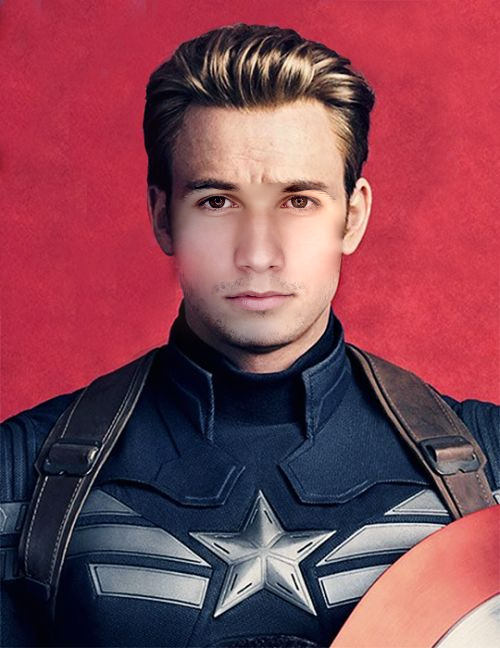

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(result)